In [1]:
# imports
from pydataset import data
import wrangle as wr
import evaluate_zillow as ev

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, RFE, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

Load in successful, awaiting commands...


In [2]:
tips = data('tips')

In [3]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


In [4]:
tips.shape

(244, 7)

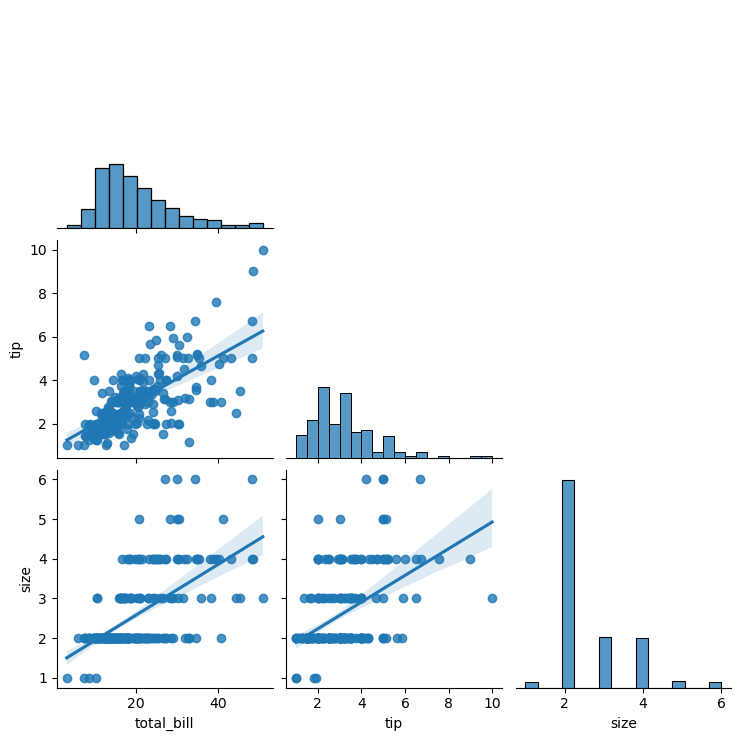

In [5]:
# use pairplot
sns.pairplot(data=tips, corner=True, kind='reg')
plt.show()

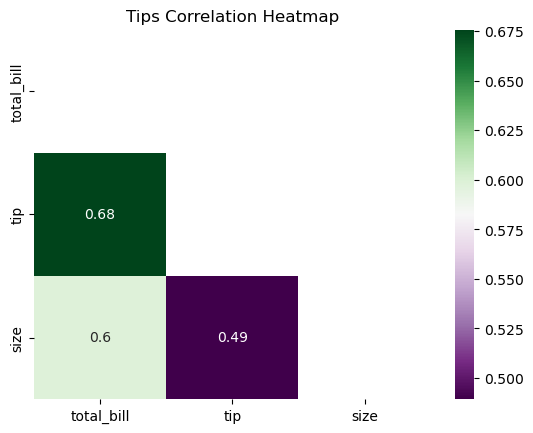

In [6]:
# use a heat map to look at corr
tips_corr = tips.corr(method='pearson')
sns.heatmap(tips_corr, cmap='PRGn', annot=True, mask=np.triu(tips_corr))
plt.title(f"Tips Correlation Heatmap")
plt.show()

### Create a column named price_per_person. This should be the total bill divided by the party size

In [7]:
# checking data types
tips.dtypes

total_bill    float64
tip           float64
sex            object
smoker         object
day            object
time           object
size            int64
dtype: object

In [8]:
# creating the column
tips['price_per_person'] = round((tips.total_bill) / tips['size'],2)
tips

,total_bill,tip,sex,smoker,day,time,size,price_per_person
1,16.99,1.01,Female,No,Sun,Dinner,2,8.49
2,10.34,1.66,Male,No,Sun,Dinner,3,3.45
3,21.01,3.50,Male,No,Sun,Dinner,3,7.00
4,23.68,3.31,Male,No,Sun,Dinner,2,11.84
5,24.59,3.61,Female,No,Sun,Dinner,4,6.15
...,...,...,...,...,...,...,...,...
240,29.03,5.92,Male,No,Sat,Dinner,3,9.68
241,27.18,2.00,Female,Yes,Sat,Dinner,2,13.59
242,22.67,2.00,Male,Yes,Sat,Dinner,2,11.34
243,17.82,1.75,Male,No,Sat,Dinner,2,8.91


In [9]:
# # map
# tips.sex = tips.sex.map({'Female':1,'Male':0})
# tips.smoker = tips.smoker.map({'Yes':1, 'No':0})
# tips.day = tips.day.map({'Sat':1, 'Sun':2,'Thur':3,'Fri':4})
# tips.time = tips.time.map({'Dinner':1,'Lunch':2})

In [10]:
tips

,total_bill,tip,sex,smoker,day,time,size,price_per_person
1,16.99,1.01,Female,No,Sun,Dinner,2,8.49
2,10.34,1.66,Male,No,Sun,Dinner,3,3.45
3,21.01,3.50,Male,No,Sun,Dinner,3,7.00
4,23.68,3.31,Male,No,Sun,Dinner,2,11.84
5,24.59,3.61,Female,No,Sun,Dinner,4,6.15
...,...,...,...,...,...,...,...,...
240,29.03,5.92,Male,No,Sat,Dinner,3,9.68
241,27.18,2.00,Female,Yes,Sat,Dinner,2,13.59
242,22.67,2.00,Male,Yes,Sat,Dinner,2,11.34
243,17.82,1.75,Male,No,Sat,Dinner,2,8.91


### Before using any of the methods discussed in the lesson, which features do you think would be most important for predicting the tip amount?

* total bill and size

In [11]:
# split and scale the data
train, test = train_test_split(tips, test_size = .2, random_state=123)
train, validate = train_test_split(train, test_size = .25, random_state=123)

In [12]:
# verify split size
train.shape, validate.shape, test.shape

((146, 8), (49, 8), (49, 8))

In [13]:
# encode categoricals off the train, validate, test and make new encoded_df
dummy_df1 = pd.get_dummies(train[['sex','smoker','day','time']],\
                           dummy_na=False, drop_first=[True, True, True, True])
dummy_df2 = pd.get_dummies(validate[['sex','smoker','day','time']],\
                           dummy_na=False, drop_first=[True, True, True, True])
dummy_df3 = pd.get_dummies(test[['sex','smoker','day','time']],\
                           dummy_na=False, drop_first=[True, True, True, True])
dummy_df1.head()

,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
225,1,1,0,0,0,1
182,1,1,0,1,0,0
103,0,1,1,0,0,0
165,0,1,0,1,0,0
74,0,1,1,0,0,0


In [14]:
# concat back to encoded_train, validate, test and drop object columns
encoded_train = pd.concat([train.drop(columns=['sex','smoker','day','time']), dummy_df1], axis = 1)
encoded_validate = pd.concat([validate.drop(columns=['sex','smoker','day','time']), dummy_df2], axis = 1)
encoded_test = pd.concat([test.drop(columns=['sex','smoker','day','time']), dummy_df3], axis = 1)

In [15]:
encoded_train.head()

,total_bill,tip,size,price_per_person,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
225,13.42,1.58,2,6.71,1,1,0,0,0,1
182,23.33,5.65,2,11.66,1,1,0,1,0,0
103,44.30,2.50,3,14.77,0,1,1,0,0,0
165,17.51,3.00,2,8.76,0,1,0,1,0,0
74,25.28,5.00,2,12.64,0,1,1,0,0,0


In [16]:
# create model variables from df
encoded_train, y_train = encoded_train.drop(columns=['tip']), encoded_train.tip
encoded_validate, y_validate = encoded_validate.drop(columns=['tip']), encoded_validate.tip
encoded_test, y_test = encoded_test.drop(columns=['tip']), encoded_test.tip

In [17]:
encoded_train.head()

,total_bill,size,price_per_person,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
225,13.42,2,6.71,1,1,0,0,0,1
182,23.33,2,11.66,1,1,0,1,0,0
103,44.30,3,14.77,0,1,1,0,0,0
165,17.51,2,8.76,0,1,0,1,0,0
74,25.28,2,12.64,0,1,1,0,0,0


In [18]:
# scale the data

# make the scaler
minmaxscaler = MinMaxScaler()

# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.

# fit the scaler on train ONLY
minmaxscaler.fit(encoded_train)

# use the scaler
encoded_train_scaled_mm = pd.DataFrame(minmaxscaler.transform(encoded_train))
encoded_validate_scaled_mm = pd.DataFrame(minmaxscaler.transform(encoded_validate))
encoded_test_scaled_mm = pd.DataFrame(minmaxscaler.transform(encoded_test))

#### Use select k best to select the top 2 features for predicting tip amount. What are they?

In [19]:
# MAKE the thing
kbest = SelectKBest(f_regression, k=2)

# FIT the thing
kbest.fit(encoded_train_scaled_mm, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x7f9260f62a60>)

In [20]:
# statistical f-value / feature's scores & p-values:
kbest.scores_, kbest.pvalues_

(array([1.11115028e+02, 5.76071336e+01, 1.38356417e+01, 5.96049171e-01,
        8.45071808e-02, 2.50128222e-02, 3.28560161e+00, 9.78681779e-01,
        2.18955757e+00]),
 array([1.30561953e-19, 3.66901154e-12, 2.85187703e-04, 4.41354619e-01,
        7.71698118e-01, 8.74556685e-01, 7.19730319e-02, 3.24183852e-01,
        1.41133637e-01]))

In [21]:
kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_),\
                             index = encoded_train.columns)
kbest_results.head()

,p,f
total_bill,1.305620e-19,111.115028
size,3.669012e-12,57.607134
price_per_person,2.851877e-04,13.835642
sex_Male,4.413546e-01,0.596049
smoker_Yes,7.716981e-01,0.084507


In [22]:
# see the top two
kbest_results.sort_values(by=['f'], ascending=False).head(2)

,p,f
total_bill,1.305620e-19,111.115028
size,3.669012e-12,57.607134


In [23]:
# uh, what?
kbest.get_support()

array([ True,  True, False, False, False, False, False, False, False])

In [24]:
# human readable
encoded_train_KBtransformed = pd.DataFrame(kbest.transform(encoded_train_scaled_mm),\
                                     columns = encoded_train.columns[kbest.get_support()],\
                                     index=encoded_train.index)
encoded_train_KBtransformed.head()

,total_bill,size
225,0.228679,0.2
182,0.447636,0.2
103,0.910959,0.4
165,0.319046,0.2
74,0.490720,0.2


### Takeaway:

I was right! Total bill and size are the top two features for KBest.

#### Use recursive feature elimination to select the top 2 features for tip amount. What are they?


In [26]:
lr = LinearRegression()

# make the thing
rfe = RFE(lr, n_features_to_select=2)

# fit the thing
rfe.fit(encoded_train_scaled_mm, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=2)

In [27]:
# Get feature ranking
# Selected features are assigned a rank 1

rfe.ranking_

array([1, 6, 1, 4, 7, 2, 8, 3, 5])

In [49]:
# human readable form
pd.DataFrame({'rfe_ranking':rfe.ranking_},index=encoded_train.columns).sort_values(by='rfe_ranking')

,rfe_ranking
total_bill,1
price_per_person,1
day_Sat,2
day_Thur,3
sex_Male,4
time_Lunch,5
size,6
smoker_Yes,7
day_Sun,8


In [29]:
rfe.get_support()

array([ True, False,  True, False, False, False, False, False, False])

In [30]:
# human readable
encoded_train_RFEtransformed = pd.DataFrame(rfe.transform(encoded_train_scaled_mm),index=encoded_train.index,
    columns = encoded_train.columns[rfe.support_])

In [31]:
encoded_train_RFEtransformed.head()

,total_bill,price_per_person
225,0.228679,0.211628
182,0.447636,0.499419
103,0.910959,0.680233
165,0.319046,0.330814
74,0.490720,0.556395


### Takeaway:

Interesting, total price and price per person.

#### Why do you think select k best and recursive feature elimination might give different answers for the top features? Does this change as you change the number of features you are selecting?

* RFE evaluates on importance to the model. Encoded variables are given more weight?

* KBest isolates each feature against the target based on correlation.

#### Write a function named select_kbest that takes in the predictors (X), the target (y), and the number of features to select (k) and returns the names of the top k selected features based on the SelectKBest class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

In [32]:
ev.select_kbest(encoded_train_scaled_mm, encoded_train, y_train, 2)

These are the top 2 columns selected from Select K Best model:


['total_bill', 'size']

#### Write a function named rfe that takes in the predictors, the target, and the number of features to select. It should return the top k features based on the RFE class. Test your function with the tips dataset. You should see the same results as when you did the process manually.



In [33]:
ev.rfe(encoded_train_scaled_mm, encoded_train, y_train, 2)

These are the top 2 columns selected from RFE model:


['total_bill', 'price_per_person']

#### Load the swiss dataset and use all the other features to predict Fertility. Find the top 3 features using both select k best and recursive feature elimination (use the functions you just built to help you out).

In [34]:
swiss = data('swiss')

In [35]:
swiss.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


In [78]:
target='Fertility'

In [65]:
swiss.dtypes

Fertility           float64
Agriculture         float64
Examination           int64
Education             int64
Catholic            float64
Infant.Mortality    float64
dtype: object

In [66]:
swiss.shape # tiny

(47, 6)

In [67]:
# split the data
train,test = train_test_split(swiss, test_size = .2, random_state=123)
train, validate = train_test_split(train, test_size = .25, random_state=123)

In [79]:
# Setup X and y
X_train = train.drop(columns=[target])
y_train = train[target]

X_validate = validate.drop(columns=[target])
y_validate = validate[target]

X_test = test.drop(columns=[target])
y_test = test[target]

In [80]:
# scale the data

# make the scaler
minmaxscaler = MinMaxScaler()

# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.

# fit the scaler on train ONLY
minmaxscaler.fit(train)

# use the scaler
train_scaled_mm = pd.DataFrame(minmaxscaler.transform(train))
validate_scaled_mm = pd.DataFrame(minmaxscaler.transform(validate))
test_scaled_mm = pd.DataFrame(minmaxscaler.transform(test))

In [81]:
train_scaled_mm.shape, validate_scaled_mm.shape, test_scaled_mm.shape

((27, 6), (10, 6), (10, 6))

In [82]:
ev.select_kbest(train_scaled_mm, train, y_train, 3)

These are the top 3 columns selected from Select K Best model:


['Fertility', 'Examination', 'Catholic']

In [84]:
ev.rfe(train_scaled_mm, train, y_train, 3)

These are the top 3 columns selected from RFE model:


['Fertility', 'Education', 'Catholic']